In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import display
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

In [3]:
dataset_dir = Path("./../Picture_resize/")  # my_dataset ディレクトリのパス

In [4]:
data_transforms = {
    # 学習時の Transform
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    # 推論時の Transform
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

In [5]:
# Dataset を作成する。
img_datasets = {
    x: datasets.ImageFolder(dataset_dir / x, data_transforms[x])
    for x in ["train", "val"]
}


In [6]:
class_names = img_datasets["train"].classes
print(class_names)

['1', '2']


In [7]:
dataloaders = {
    x: data.DataLoader(img_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}

In [8]:
def get_device(gpu_id=-1):
    if gpu_id >= 0 and torch.cuda.is_available():
        return torch.device("cuda", gpu_id)
    else:
        return torch.device("cpu")


device = get_device(gpu_id=0)

In [9]:
def train(model, criterion, optimizer, scheduler, dataloaders, device, n_epochs):
    """指定したエポック数だけ学習する。
    """
    history = []
    for epoch in range(n_epochs):
        info = train_on_epoch(
            model, criterion, optimizer, scheduler, dataloaders, device
        )
        info["epoch"] = epoch + 1
        history.append(info)

        print(
            f"epoch {info['epoch']:<2} "
            f"[train] loss: {info['train_loss']:.6f}, accuracy: {info['train_accuracy']:.0%} "
            f"[test] loss: {info['val_loss']:.6f}, accuracy: {info['val_accuracy']:.0%}"
        )
    history = pd.DataFrame(history)

    return history

In [10]:
def train_on_epoch(model, criterion, optimizer, scheduler, dataloaders, device):
    """1エポックだけ学習する学習する。
    """
    info = {}
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # モデルを学習モードに設定する。
        else:
            model.eval()  # モデルを推論モードに設定する。

        total_loss = 0
        total_correct = 0
        for inputs, labels in dataloaders[phase]:
            # データ及びラベルを計算を実行するデバイスに転送する。
            inputs, labels = inputs.to(device), labels.to(device)

            # 学習時は勾配を計算するため、set_grad_enabled(True) で中間層の出力を記録するように設定する。
            with torch.set_grad_enabled(phase == "train"):
                # 順伝搬を行う。
                outputs = model(inputs)
                # 確率の最も高いクラスを予測ラベルとする。
                preds = outputs.argmax(dim=1)

                # 損失関数の値を計算する。
                loss = criterion(outputs, labels)

                if phase == "train":
                    # 逆伝搬を行う。
                    optimizer.zero_grad()
                    loss.backward()

                    # パラメータを更新する。
                    optimizer.step()

            # この反復の損失及び正答数を加算する。
            total_loss += float(loss)
            total_correct += int((preds == labels).sum())

        if phase == "train":
            # 学習率を調整する。
            scheduler.step()

        # 損失関数の値の平均及び精度を計算する。
        info[f"{phase}_loss"] = total_loss / len(dataloaders[phase].dataset)
        info[f"{phase}_accuracy"] = total_correct / len(dataloaders[phase].dataset)

    return info

In [11]:
def plot_history(history):
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 3))

    # 損失の推移
    ax1.set_title("Loss")
    ax1.plot(history["epoch"], history["train_loss"], label="train")
    ax1.plot(history["epoch"], history["val_loss"], label="val")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # 精度の推移
    ax2.set_title("Accuracy")
    ax2.plot(history["epoch"], history["train_accuracy"], label="train")
    ax2.plot(history["epoch"], history["val_accuracy"], label="val")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

In [12]:
# ResNet-18 を作成する。
model_ft = models.resnet18(pretrained=True)

# 出力層の出力数を ImageNet の 1000 からこのデータセットのクラス数である 2 に置き換える。
model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))

# モデルを計算するデバイスに転送する。
model_ft = model_ft.to(device)

# 損失関数を作成する。
criterion = nn.CrossEntropyLoss()

# 最適化手法を選択する。
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epoch 1  [train] loss: 0.169095, accuracy: 62% [test] loss: 0.111886, accuracy: 74%
epoch 2  [train] loss: 0.106555, accuracy: 82% [test] loss: 0.037056, accuracy: 93%
epoch 3  [train] loss: 0.152809, accuracy: 76% [test] loss: 0.344484, accuracy: 67%
epoch 4  [train] loss: 0.061055, accuracy: 91% [test] loss: 0.056526, accuracy: 88%
epoch 5  [train] loss: 0.077445, accuracy: 89% [test] loss: 0.085771, accuracy: 88%
epoch 6  [train] loss: 0.103161, accuracy: 84% [test] loss: 0.043728, accuracy: 93%
epoch 7  [train] loss: 0.113331, accuracy: 87% [test] loss: 0.156571, accuracy: 81%
epoch 8  [train] loss: 0.129587, accuracy: 82% [test] loss: 0.096373, accuracy: 79%
epoch 9  [train] loss: 0.075007, accuracy: 86% [test] loss: 0.064454, accuracy: 84%
epoch 10 [train] loss: 0.032169, accuracy: 95% [test] loss: 0.051677, accuracy: 93%


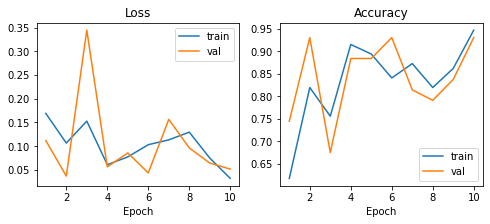

In [13]:
n_epochs = 10  # エポック数
history = train(
    model_ft, criterion, optimizer, scheduler, dataloaders, device, n_epochs
)

plot_history(history)

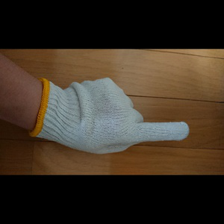

1


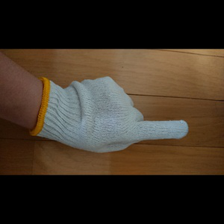

1


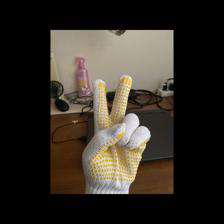

2


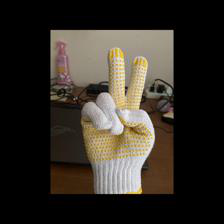

2


In [20]:
def show_prediction(model, transform, imgs, n=3):
    for img in imgs:
        # 1. PIL Image を標準化したテンソルにする。
        # 2. バッチ次元を追加する。 (C, H, W) -> (1, C, H, W)
        # 3. 計算するデバイスに転送する。
        inputs = transform(img).unsqueeze(dim=0).to(device)

        with torch.no_grad():
            # 順伝搬を行う。
            outputs = model(inputs)

            # 確率の最も高いクラスを予測ラベルとする。
            class_id = int(outputs.argmax(dim=1)[0])

        # 推論結果を表示する。
        display.display(img.resize((224, 224)))
        print(class_names[class_id])


imgs = []
for class_dir in (dataset_dir / "val").iterdir():
    for img_path in sorted(class_dir.iterdir())[:2]:
        img = Image.open(img_path)
        imgs.append(img)

show_prediction(model_ft, data_transforms["val"], imgs)